In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORTS

In [2]:
import librosa
from scipy import signal

import IPython.display as ipd

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as K



# LOADING DATA

In [3]:
path='drive/MyDrive/Emergency_vs_non-emergency_vehicle_sound_classification/'

emergency, sample_rate = librosa.load(path + 'emergency.wav', sr = 16000)

non_emergency, sample_rate= librosa.load(path + 'non emergency.wav', sr =16000)

In [4]:
# duration of clips
duration1 = librosa.get_duration(emergency, sr = 16000)
duration2 = librosa.get_duration(non_emergency, sr = 16000)

print("Duration of an emergency and Non Emergency (in min):", duration1/60, duration2/60)

Duration of an emergency and Non Emergency (in min): 22.920290625 27.160834375


# PREPARING DATA

In [5]:
# Breaking the audio into chunks of 2 seconds
def prepare_data(samples, num_of_samples = 32000, num_of_common = 16000):
  
  data=[]
  for offset in range(0, len(samples), num_of_common):
    start = offset
    end   = offset + num_of_samples
    chunk = samples[start:end]
    
    if(len(chunk)==32000):
      data.append(chunk)
    
  return data

In [6]:
emergency = prepare_data(emergency)
non_emergency = prepare_data(non_emergency)

In [7]:
print("No. of Chunks of Emergency and Non Emergency:", len(emergency), len(non_emergency))

No. of Chunks of Emergency and Non Emergency: 1374 1628


Text(0, 0.5, 'Amplitude')

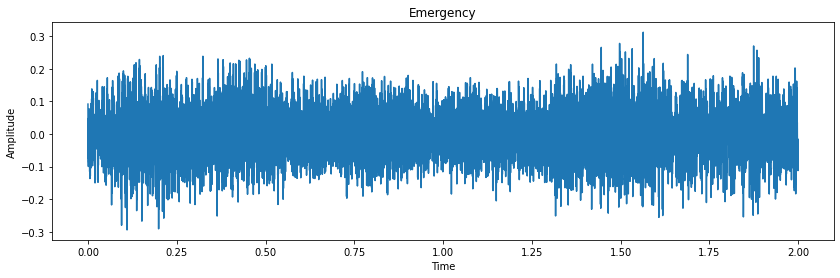

In [8]:
# Visualizing the audio
plt.figure(figsize = (14, 4))
plt.plot(np.linspace(0, 2, num = 32000), emergency[103])
plt.title('Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

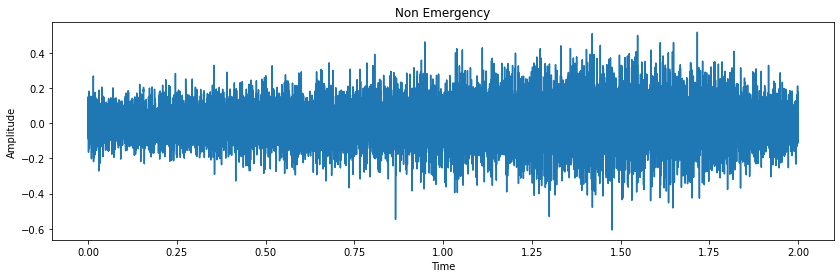

In [9]:
plt.figure(figsize = (14, 4))
plt.plot(np.linspace(0, 2, num = 32000), non_emergency[102])
plt.title('Non Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [10]:
# Combine Emergecy and Non Emergency chunks
audio = np.concatenate([emergency,non_emergency])

In [11]:
# Creating labels
labels1 = np.zeros(len(emergency))
labels2 = np.ones(len(non_emergency))
labels = np.concatenate([labels1,labels2])

In [12]:
print(audio.shape)

(3002, 32000)


In [13]:
labels.shape

(3002,)

# TRAIN / VAL SPLIT

In [14]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(audio), np.array(labels), stratify = labels, test_size = 0.1, random_state = 777, shuffle = True)

In [15]:
# x_tr(2701, 32000)
x_tr_features  = x_tr.reshape(len(x_tr), -1, 1)
# x_tr_features(2701, 32000, 1)
# x_val(301, 32000)
x_val_features = x_val.reshape(len(x_val),-1,1)
# x_val_features(301, 32000, 1)

# MODEL

In [16]:

def conv1d(x_tr):
  K.clear_session()
  inputs = Input(shape=(x_tr.shape[1], x_tr.shape[2]))

  #First Conv1D layer
  conv = Conv1D(8, 13, padding='same', activation='relu')(inputs)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)

  #Second Conv1D layer
  conv = Conv1D(16, 11, padding='same', activation='relu')(conv)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)

  #MaxPooling 1D
  conv = GlobalMaxPool1D()(conv)

  #Dense Layer 
  conv = Dense(16, activation='relu')(conv)
  outputs = Dense(1,activation='sigmoid')(conv)

  model = Model(inputs, outputs)
  
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  
  return model, model_checkpoint

In [17]:
model, model_checkpoint = conv1d(x_tr_features)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32000, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 32000, 8)          112       
_________________________________________________________________
dropout (Dropout)            (None, 32000, 8)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16000, 8)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 16)         1424      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16000, 16)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8000, 16)          0     

In [19]:
history = model.fit(x_tr_features, y_tr , epochs = 10, callbacks=[model_checkpoint], batch_size = 32, validation_data = (x_val_features, y_val))

Epoch 1/10
85/85 [==============================] - 9s 26ms/step - loss: 0.6577 - acc: 0.6263 - val_loss: 0.5880 - val_acc: 0.7608

Epoch 00001: val_acc improved from -inf to 0.76080, saving model to best_model.hdf5
Epoch 2/10
85/85 [==============================] - 2s 21ms/step - loss: 0.4858 - acc: 0.8097 - val_loss: 0.4738 - val_acc: 0.8140

Epoch 00002: val_acc improved from 0.76080 to 0.81395, saving model to best_model.hdf5
Epoch 3/10
85/85 [==============================] - 2s 21ms/step - loss: 0.4063 - acc: 0.8414 - val_loss: 0.4166 - val_acc: 0.8472

Epoch 00003: val_acc improved from 0.81395 to 0.84718, saving model to best_model.hdf5
Epoch 4/10
85/85 [==============================] - 2s 21ms/step - loss: 0.3450 - acc: 0.8686 - val_loss: 0.3886 - val_acc: 0.8638

Epoch 00004: val_acc improved from 0.84718 to 0.86379, saving model to best_model.hdf5
Epoch 5/10
85/85 [==============================] - 2s 21ms/step - loss: 0.3169 - acc: 0.8739 - val_loss: 0.3761 - val_acc: 0.8

In [20]:
model.load_weights('best_model.hdf5')

In [21]:
_ , acc = model.evaluate(x_val_features, y_val)
print("Validation Accuracy:", acc)

10/10 [==============================] - 0s 10ms/step - loss: 0.3562 - acc: 0.8904
Validation Accuracy: 0.8903654217720032


# INFERENCE

In [22]:
ind=35
test_audio = x_val[ind]
ipd.Audio(test_audio, rate = 16000)

In [23]:
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,1))
if (prob[0][0] < 0.5 ):
  pred='emergency'
else:
  pred='non emergency' 

print("Prediction:",pred)

Prediction: emergency


# LSTM MODEL

In [24]:
# x_tr(2701, 32000)
x_tr_features  = x_tr.reshape(len(x_tr), -1, 160)
# x_tr_features(2701, 200, 160)
# x_val(301, 32000)
x_val_features = x_val.reshape(len(x_val), -1, 160)
# x_val_features(301, 200, 160)

In [25]:
def lstm(x_tr):
  K.clear_session()
  inputs = Input(shape=(x_tr.shape[1], x_tr.shape[2]))

  #lstm
  x = LSTM(128)(inputs)
  x = Dropout(0.3)(x)
  
  x= Dense(64,activation='relu')(x)
  x= Dense(1,activation='sigmoid')(x)
  
  model = Model(inputs, x)

  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

  mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

  return model, mc

In [26]:
model, mc = lstm(x_tr_features)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 160)]        0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               147968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 156,289
Trainable params: 156,289
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(x_tr_features, y_tr, epochs = 10, callbacks=[mc], batch_size = 32, validation_data = (x_val_features, y_val))

Epoch 1/10
85/85 [==============================] - 3s 19ms/step - loss: 0.6836 - acc: 0.5659 - val_loss: 0.6543 - val_acc: 0.6379

Epoch 00001: val_acc improved from -inf to 0.63787, saving model to best_model.hdf5
Epoch 2/10
85/85 [==============================] - 1s 15ms/step - loss: 0.6429 - acc: 0.6634 - val_loss: 0.6361 - val_acc: 0.6478

Epoch 00002: val_acc improved from 0.63787 to 0.64784, saving model to best_model.hdf5
Epoch 3/10
85/85 [==============================] - 1s 15ms/step - loss: 0.6254 - acc: 0.6544 - val_loss: 0.5910 - val_acc: 0.6545

Epoch 00003: val_acc improved from 0.64784 to 0.65449, saving model to best_model.hdf5
Epoch 4/10
85/85 [==============================] - 1s 15ms/step - loss: 0.5752 - acc: 0.6961 - val_loss: 0.5975 - val_acc: 0.7010

Epoch 00004: val_acc improved from 0.65449 to 0.70100, saving model to best_model.hdf5
Epoch 5/10
85/85 [==============================] - 1s 15ms/step - loss: 0.5510 - acc: 0.7316 - val_loss: 0.5465 - val_acc: 0.7

In [29]:
model.load_weights('best_model.hdf5')

In [30]:
_, acc = model.evaluate(x_val_features, y_val)
print("Accuracy:", acc)

10/10 [==============================] - 0s 8ms/step - loss: 0.4302 - acc: 0.8106
Accuracy: 0.8106312155723572


In [31]:
ind = 1
test_audio = x_val[ind]
ipd.Audio(test_audio, rate = 16000)

In [32]:
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1, -1, feature.shape[1]))
if (prob[0][0] < 0.5 ):
  pred='emergency'
else:
  pred='non emergency' 
print("Prediction:",pred)

Prediction: emergency


# SPECTOGRAM

In [33]:
def log_specgram(audio, sample_rate, eps=1e-10):
    freqs, times, spec = signal.spectrogram(audio, fs = sample_rate, nperseg = 320, noverlap = 160, detrend = False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [34]:
def plot(spectrogram, label):
  fig = plt.figure(figsize = (14, 8))
  plt.imshow(spectrogram.T, aspect='auto', origin='lower', extent=[times.min(), times.max(), freqs.min(), freqs.max()])
  plt.title('Spectrogram of '+label)
  plt.ylabel('Freqs in Hz')
  plt.xlabel('Seconds')

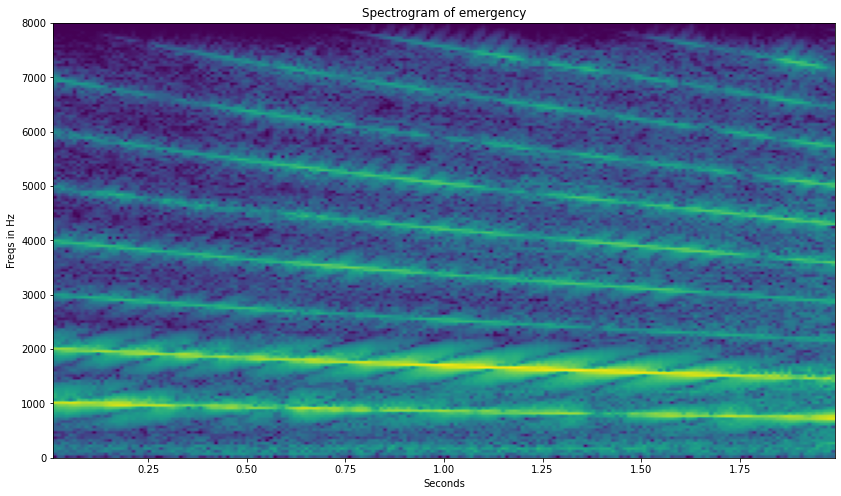

In [35]:
freqs, times, spectrogram = log_specgram(emergency[300], sample_rate)
plot(spectrogram,"emergency")

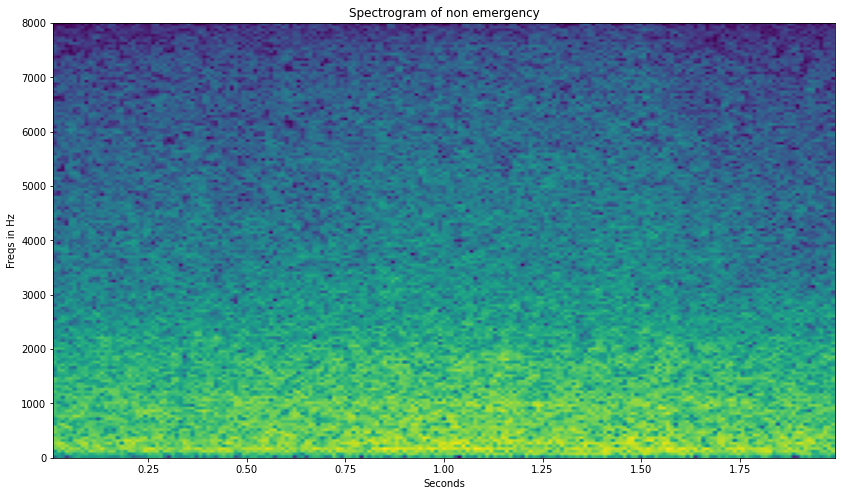

In [36]:
freqs, times, spectrogram = log_specgram(non_emergency[300], sample_rate)
plot(spectrogram,"non emergency")

In [37]:
spectrogram.shape

(199, 161)

In [38]:
# Extract the spectrogram features
def extract_spectrogram_features(x_tr):
  features=[]
  for i in x_tr:
    _, _, spectrogram = log_specgram(i, sample_rate)
    
    mean = np.mean(spectrogram, axis=0)
    std = np.std(spectrogram, axis=0)
    spectrogram = (spectrogram - mean) / std
    
    features.append(spectrogram)

  return np.array(features)

In [39]:
x_tr_features  = extract_spectrogram_features(x_tr)
x_val_features = extract_spectrogram_features(x_val)

# MODEL

In [40]:
model, mc = lstm(x_tr_features)

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 199, 161)]        0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               148480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 156,801
Trainable params: 156,801
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(x_tr_features, y_tr, epochs = 10, callbacks=[mc], batch_size = 32, validation_data = (x_val_features, y_val))

Epoch 1/10
85/85 [==============================] - 3s 20ms/step - loss: 0.6781 - acc: 0.5546 - val_loss: 0.5808 - val_acc: 0.7143

Epoch 00001: val_acc improved from -inf to 0.71429, saving model to best_model.hdf5
Epoch 2/10
85/85 [==============================] - 1s 16ms/step - loss: 0.4519 - acc: 0.8134 - val_loss: 0.3992 - val_acc: 0.8339

Epoch 00002: val_acc improved from 0.71429 to 0.83389, saving model to best_model.hdf5
Epoch 3/10
85/85 [==============================] - 1s 15ms/step - loss: 0.3339 - acc: 0.8750 - val_loss: 0.3549 - val_acc: 0.8472

Epoch 00003: val_acc improved from 0.83389 to 0.84718, saving model to best_model.hdf5
Epoch 4/10
85/85 [==============================] - 1s 15ms/step - loss: 0.3112 - acc: 0.8760 - val_loss: 0.3558 - val_acc: 0.8638

Epoch 00004: val_acc improved from 0.84718 to 0.86379, saving model to best_model.hdf5
Epoch 5/10
85/85 [==============================] - 1s 15ms/step - loss: 0.2242 - acc: 0.9181 - val_loss: 0.2339 - val_acc: 0.9

In [43]:
model.load_weights('best_model.hdf5')

In [44]:
_,acc = model.evaluate(x_val_features,  y_val)
print("Accuracy:", acc)

10/10 [==============================] - 0s 8ms/step - loss: 0.1836 - acc: 0.9468
Accuracy: 0.9468438625335693


# INFERENCE

In [45]:
ind=1
test_audio = x_val[ind]
ipd.Audio(test_audio, rate = 16000)

In [46]:
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,feature.shape[1]))
if (prob[0][0] < 0.5 ):
  pred='emergency'
else:
  pred='non emergency' 
print("Prediction:",pred)

Prediction: emergency


# CONV1D ON SPECTOGRAM FEATURES

In [47]:
model, mc = conv1d(x_tr_features)

In [48]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 199, 161)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 199, 8)            16752     
_________________________________________________________________
dropout (Dropout)            (None, 199, 8)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 99, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 99, 16)            1424      
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 16)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 16)            0     

In [49]:
history = model.fit(x_tr_features, y_tr, epochs = 10, callbacks=[mc], batch_size = 32, validation_data = (x_val_features, y_val))

Epoch 1/10
85/85 [==============================] - 1s 8ms/step - loss: 0.6514 - acc: 0.6335 - val_loss: 0.4564 - val_acc: 0.8538

Epoch 00001: val_acc improved from -inf to 0.85382, saving model to best_model.hdf5
Epoch 2/10
85/85 [==============================] - 1s 9ms/step - loss: 0.3343 - acc: 0.8700 - val_loss: 0.3241 - val_acc: 0.8904

Epoch 00002: val_acc improved from 0.85382 to 0.89037, saving model to best_model.hdf5
Epoch 3/10
85/85 [==============================] - 1s 6ms/step - loss: 0.2245 - acc: 0.9117 - val_loss: 0.2761 - val_acc: 0.9236

Epoch 00003: val_acc improved from 0.89037 to 0.92359, saving model to best_model.hdf5
Epoch 4/10
85/85 [==============================] - 0s 5ms/step - loss: 0.1764 - acc: 0.9328 - val_loss: 0.2302 - val_acc: 0.9203

Epoch 00004: val_acc did not improve from 0.92359
Epoch 5/10
85/85 [==============================] - 0s 6ms/step - loss: 0.1268 - acc: 0.9504 - val_loss: 0.1984 - val_acc: 0.9435

Epoch 00005: val_acc improved from 0.

In [50]:
model.load_weights('best_model.hdf5')

In [51]:
_, acc = model.evaluate(x_val_features, y_val)
print("Accuracy:", acc)

10/10 [==============================] - 0s 4ms/step - loss: 0.1461 - acc: 0.9635
Accuracy: 0.9634551405906677


# INFERENCE

In [52]:
ind=1
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)

In [53]:
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,feature.shape[1]))
if (prob[0][0] < 0.5 ):
  pred='emergency'
else:
  pred='non emergency' 

print("Predicion:",pred)

Predicion: emergency
